<a href="https://colab.research.google.com/github/Ulisex666/MLP-with-classic-optimization/blob/main/MLP_OI_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Primera versión MLP

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import gdown
# Este apartado carga la base de datos iris desde el Drive del proyecto.
# ID del archivo en Google Drive
file_id = '1uc7uW6-Y4tdqfxE2SrnyiHM7hTa05XLM'

# URL de descarga
url = f'https://drive.google.com/uc?id={file_id}'

# Nombre del archivo descargado
output = 'mi_archivo.csv'

# Descargar el archivo
gdown.download(url, output, quiet=False)

# Cargar el archivo CSV
import pandas as pd
df = pd.read_csv(output)

# Mostrar las primeras filas del archivo
print(df.head())

Downloading...
From: https://drive.google.com/uc?id=1uc7uW6-Y4tdqfxE2SrnyiHM7hTa05XLM
To: /content/mi_archivo.csv
100%|██████████| 3.98k/3.98k [00:00<00:00, 10.2MB/s]

   sepal.length  sepal.width  petal.length  petal.width variety
0           5.1          3.5           1.4          0.2  Setosa
1           4.9          3.0           1.4          0.2  Setosa
2           4.7          3.2           1.3          0.2  Setosa
3           4.6          3.1           1.5          0.2  Setosa
4           5.0          3.6           1.4          0.2  Setosa


In [ ]:
# La última columna 'variety' contiene las etiquetas de las clases
X = df.iloc[:, :-1].values  # Características (todas las columnas excepto la última)
y = df.iloc[:, -1].values   # Etiquetas (última columna)

# Aplicar One-Hot Encoding a las etiquetas
encoder = OneHotEncoder(sparse_output=False)
y_onehot = encoder.fit_transform(y.reshape(-1, 1))

In [ ]:
# Crear un estandarizador
scaler = StandardScaler()

# Estandarizar las características
X_standardized = scaler.fit_transform(X)

In [ ]:
# División del dataset en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_standardized, y_onehot, test_size=0.2, random_state=42)

In [ ]:
# Clase MLP
class MLP:
    def __init__(self, input_size, hidden_size, output_size, learning_rate=0.01):
        # Inicialización de pesos y sesgos para un MLP con 2 hidden layers.
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.learning_rate = learning_rate

        # Matrices de pesos para cada conexión de nodos entre capas ocultas y output layer, se multiplica por 0.01
        # dadas las recomendaciones de iniciar con valores pequeños para los pesos.
        self.W1 = np.random.randn(self.input_size, self.hidden_size)
        self.W2 = np.random.randn(self.hidden_size, self.hidden_size)
        self.W3 = np.random.randn(self.hidden_size, self.output_size)

        # Sesgos iniciales, ceros en un principio, toman la dimensión de las capas a las que se dirigen
        self.b1 = np.zeros((1, self.hidden_size))
        self.b2 = np.zeros((1, self.hidden_size))
        self.b3 = np.zeros((1, self.output_size))

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def sigmoid_derivative(self, x):
        return x * (1 - x)

    def forward(self, X):
        # Feed forward propagation
        # Multiplicación entre valores de entrenamiento y pesos, agregando el bias asignado a cada conexión
        self.Z1 = np.dot(X, self.W1) + self.b1
        self.A1 = self.sigmoid(self.Z1)

        self.Z2 = np.dot(self.A1, self.W2) + self.b2
        self.A2 = self.sigmoid(self.Z2)

        # Se ejecuta este proceso hasta obtener los valores de los nodos en el output layer
        self.Z3 = np.dot(self.A2, self.W3) + self.b3
        self.A3 = self.sigmoid(self.Z3)

        # Al final, devuelve la activación de la output layer, estos son los valores que nos servirán para hacer predicciones
        # con nuestro modelo.

        # REVISAR ESTAS ACTIVACIONES Y CÓMO SE RELACIONAN CON LA PREDICCIÓN.
        return self.A3

    def back_prop(self, X, y):
        # Cálculo del error y retropropagación
        m = X.shape[0]

        # Error de la capa de salida
        # Se calcula el error absoluto en la capa de salida, es decir, nuestra predicción menos los valores reales.
        dA3 = self.A3 - y
        # Este valor se multiplica por la derivada de la función de activación evaluada en las predicciones
        dZ3 = dA3 * self.sigmoid_derivative(self.A3)
        # Se ejecutan los cambios en los pesos para las conexiones entre última hidden layer y output layer
        # REVISAR LA DIVISIÓN ENTRE m.
        dW3 = np.dot(self.A2.T, dZ3) / m
        db3 = np.sum(dZ3, axis=0, keepdims=True) / m

        # Error de la segunda capa oculta, se repite el proceso anterior, utilizando como diferencia los valores predichos antes
        # y comparandolos con los pesos actuales, esto permite calcular el error en los anteriores valores que se estimaron.
        dA2 = np.dot(dZ3, self.W3.T)
        dZ2 = dA2 * self.sigmoid_derivative(self.A2)
        dW2 = np.dot(self.A1.T, dZ2) / m
        db2 = np.sum(dZ2, axis=0, keepdims=True) / m

        # Error de la primera capa oculta
        dA1 = np.dot(dZ2, self.W2.T)
        dZ1 = dA1 * self.sigmoid_derivative(self.A1)
        dW1 = np.dot(X.T, dZ1) / m
        db1 = np.sum(dZ1, axis=0, keepdims=True) / m

        # Actualización de pesos y sesgos, multiplicándolos por el learning rate.
        self.W1 -= self.learning_rate * dW1
        self.W2 -= self.learning_rate * dW2
        self.W3 -= self.learning_rate * dW3

        self.b1 -= self.learning_rate * db1
        self.b2 -= self.learning_rate * db2
        self.b3 -= self.learning_rate * db3


    # Entrenamiento
    def train(self, X_train, y_train, epochs):
        error_history = []
        for epoch in range(epochs):
            # Propagación hacia adelante con conjunto de entrenamiento
            y_pred = self.forward(X_train)

            # Cálculo del error cuadrático medio
            error = np.mean(np.square(y_train - y_pred))
            error_history.append(error)

            # Retropropagación y actualización de pesos
            self.back_prop(X_train, y_train)

            if epoch % 100 == 0:
                print(f'Epoch {epoch}/{epochs}, Error: {error}')

        return error_history

    # Predicción
    def predict(self, X_test, y_test):
        # Se guardan las predicciones del modelo
        pred = self.forward(X_test)
        pred = (pred == pred.max(axis=1, keepdims=True)).astype(int)
        accuracy = np.mean(np.all(pred == y_test, axis=1))
        print(f"Accuracy: {accuracy}")

In [ ]:
# Creamos el objeto mlp que será una instancia de la clase MLP con parámetros concretos
# es decir, el modelo se entrena con los parámetros y obtenemos un modelo entrenado con dichos parámetros
# esto se puede utilizar para realizar predicciones futuras.
mlp = MLP(input_size=4, hidden_size=10, output_size=3, learning_rate=0.1)
error_history = mlp.train(X_train, y_train, epochs=1000)

Epoch 0/1000, Error: 0.5844128951748344
Epoch 100/1000, Error: 0.39465389831198056
Epoch 200/1000, Error: 0.22209098812969716
Epoch 300/1000, Error: 0.19540151763576108
Epoch 400/1000, Error: 0.17493537439088439
Epoch 500/1000, Error: 0.15378220438299656
Epoch 600/1000, Error: 0.13655631572485205
Epoch 700/1000, Error: 0.12418960128644912
Epoch 800/1000, Error: 0.11521800233763674
Epoch 900/1000, Error: 0.10831167258339215


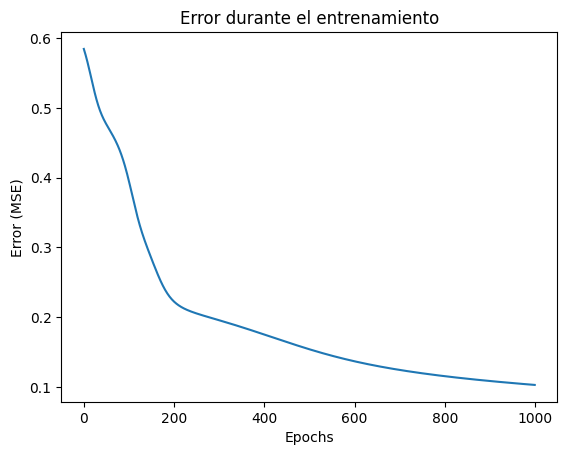

In [ ]:
# Graficar el error durante el entrenamiento
plt.plot(error_history)
plt.title('Error durante el entrenamiento')
plt.xlabel('Epochs')
plt.ylabel('Error (MSE)')
plt.show()

In [ ]:
# mlp con datos de prueba
mlp.predict(X_test, y_test)

Accuracy: 0.9
